# Simulated toy data example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bhad.utils import mvt2mixture
from bhad.model import BHAD

### Draw from a two-component multivariate Student-t mixture distribution

Note: Anomaly class corresponds to the minority mixture component

In [2]:
seed = 42  
outlier_prob_true = .01         # probab. for outlier ; should be consistent with contamination rate in your model
k = 30                          # feature dimension 
N = 5*10**4                     # sample size

# Specify first and second moments for each component  
bvt = mvt2mixture(thetas = {'mean1' : np.full(k,-1), 'mean2' : np.full(k,.5), 
                                'Sigma1' : np.eye(k)*.4, 'Sigma2' : np.eye(k)*.1, 
                                'nu1': 3.*k, 'nu2': 3.*k}, seed = seed, gaussian = False)

# Get latent draws and observations:
#------------------------------------
y_true, dataset = bvt.draw(n_samples = N, k = k, p = outlier_prob_true)

print(dataset.shape)

(50000, 30)


In [3]:
y_true.mean()    # probab. latent class 1 (=anomaly)

0.01024

### Visualize your data:

Reduce dimension for visualization only:

In [4]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(dataset)

X_reduce = TruncatedSVD(n_components=3).fit_transform(X)

### Plot all the ground truth points together with the predictions

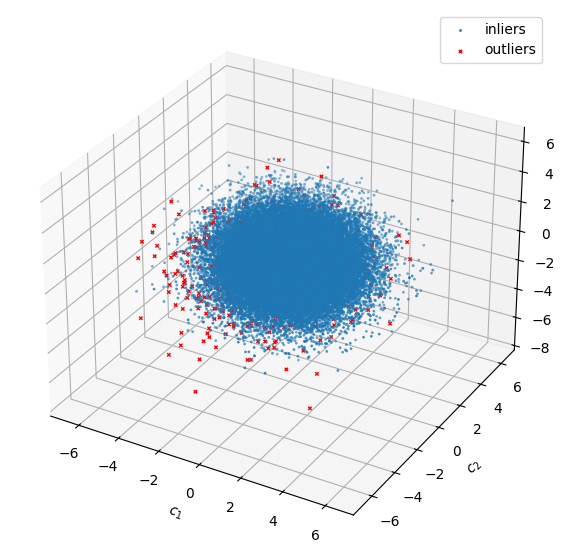

In [5]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'$c_{1}$') ; ax.set_ylabel(r'$c_{2}$') ;ax.set_zlabel(r'$c_{3}$')

# Plot the compressed inliers data points
ax.scatter(X_reduce[y_true == 0, 0], X_reduce[y_true == 0, 1], zs=X_reduce[y_true == 0, 2], s=4, lw=0, label = "inliers")

# outliers
ax.scatter(X_reduce[y_true == 1, 0], X_reduce[y_true == 1, 1], zs=X_reduce[y_true == 1, 2], 
           lw=1, s=6, marker="x", c="red", alpha=1, label = "outliers")
ax.legend()
plt.show();

Partition your dataset:

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, y_true, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(33500, 30)
(16500, 30)
(array([0, 1]), array([33147,   353]))
(array([0, 1]), array([16341,   159]))


Use another candidate anomaly detector for comparison:

In [7]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection

# Tune hyperparameters for fair comparison
param_grid = {
    'contamination': [outlier_prob_true], 
    'max_features': [10, 20, 30], 
    'bootstrap': [True, False], 
    'n_estimators': [50, 100, 200]
}

f1sc = make_scorer(f1_score, average='macro')

grid_search = model_selection.GridSearchCV(
    IsolationForest(), 
    param_grid,
    scoring=f1sc, 
    refit=True,
    cv=3, 
    return_train_score=True,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",IsolationForest()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'bootstrap': [True, False], 'contamination': [0.01], 'max_features': [10, 20, ...], 'n_estimators': [50, 100, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",make_scorer(f...average=macro)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and p

In [8]:
# Best model and parameters
best_iso_forest = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

# Predict anomalies
y_pred_train = best_iso_forest.predict(X_train)
y_pred_test = best_iso_forest.predict(X_test)
# -1 indicates anomalies, 1 indicates normal points

print(np.unique(y_pred_train, return_counts=True))
print(np.unique(y_pred_test, return_counts=True))

Best Parameters: {'bootstrap': True, 'contamination': 0.01, 'max_features': 20, 'n_estimators': 50}
(array([-1,  1]), array([  335, 33165]))
(array([-1,  1]), array([  149, 16351]))


In [9]:
from sklearn.metrics import classification_report

# Make comparable to y_true encoding in DGP above
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

print(classification_report(y_test, y_pred_test, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00     16341
     Outlier       0.89      0.83      0.86       159

    accuracy                           1.00     16500
   macro avg       0.94      0.91      0.93     16500
weighted avg       1.00      1.00      1.00     16500



### Model training and prediction

In [10]:
model = BHAD(
    contamination=outlier_prob_true,                  # set 1% contamination as in DGP (oracle knowledge ;)
    nbins=None,                       # step only needed if continous features are present
    verbose=True
)

y_pred_train = model.fit_predict(X_train)
scores_train = model.decision_function(X_train)

print("Training predictions:", np.unique(y_pred_train, return_counts=True))


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Discretizing continuous features...
Setting maximum number of bins 184.
Input shape: (33500, 30)
Used 30 numeric feature(s) and 0 categorical feature(s).
Determining optimal number of bins for numeric features
Feature var0 using 49 bins
Determining optimal number of bins for numeric features
Feature var1 using 61 bins
Determining optimal number of bins for numeric features
Feature var2 using 42 bins
Determining optimal number of bins for numeric features
Feature var3 using 52 bins
Determining optimal number of bins for numeric features
Feature var4 using 46 bins
Determining optimal number of bins for numeric features
Feature var5 using 51 bins
Determining optimal number of bins for numeric features
Feature var6 using 51 bins
Determining optimal number of bins for numeric features
Feature var7 using 51 bins
Determining optimal number of bins for numeric features
Feature var8 using 55 bins
Determining optimal number of bins for num

In [11]:
print(np.unique(y_pred_train, return_counts=True))

(array([-1,  1]), array([  337, 33163]))


In [12]:
# Get scores first, then derive predictions (avoids processing X_test twice)
scores_test = model.decision_function(X_test)
y_pred_test = model.predict(X_test)

print(np.unique(y_pred_test, return_counts=True))


Score input data.
Apply fitted one-hot encoder.

Score input data.
Apply fitted one-hot encoder.
(array([-1,  1]), array([  149, 16351]))


Plot score distribution:

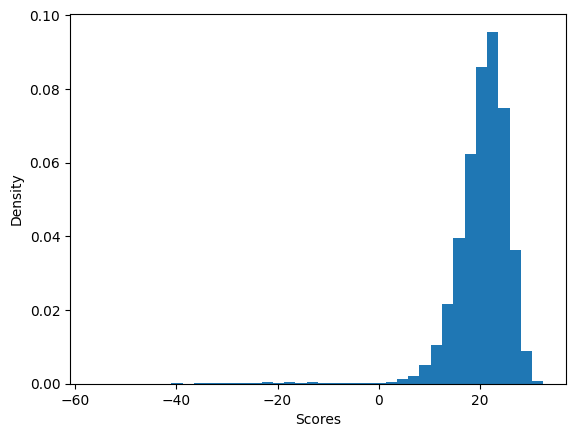

In [13]:
plt.hist(scores_train, density=True, bins=40) 
plt.ylabel('Density')
plt.xlabel('Scores');

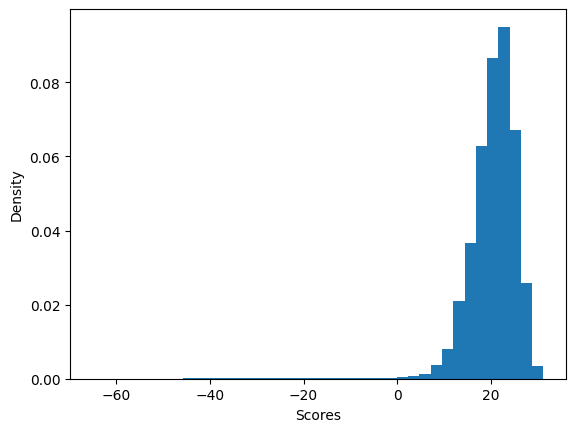

In [14]:
plt.hist(scores_test, density=True, bins=40) 
plt.ylabel('Density')
plt.xlabel('Scores');

In [15]:
from sklearn.metrics import classification_report

# Make comparable to y_true encoding
y_pred_train[y_pred_train == 1] = 0
y_pred_train[y_pred_train == -1] = 1

print(classification_report(y_train, y_pred_train, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00     33147
     Outlier       0.97      0.93      0.95       353

    accuracy                           1.00     33500
   macro avg       0.98      0.96      0.97     33500
weighted avg       1.00      1.00      1.00     33500



In [16]:
# Make comparable to y_true encoding
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

print(classification_report(y_test, y_pred_test, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00     16341
     Outlier       0.98      0.92      0.95       159

    accuracy                           1.00     16500
   macro avg       0.99      0.96      0.97     16500
weighted avg       1.00      1.00      1.00     16500



## Model explanation:

Retrieve local model explanations. Here: Specify all numeric and categorical columns explicitly

In [17]:
num_cols = list(X_train.select_dtypes(include=['float', 'int']).columns) 
cat_cols = list(X_train.select_dtypes(include=['object', 'category']).columns)

In [18]:
model = BHAD(
    contamination = 0.01, 
    num_features = num_cols, cat_features = cat_cols,                 
    nbins=50,                      
    verbose=True
)

y_pred_train = model.fit_predict(X_train)


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Discretizing continuous features...
Setting maximum number of bins 184.
Input shape: (33500, 30)
Used 30 numeric feature(s) and 0 categorical feature(s).
Binned continous features into 50 bins.
Fit BHAD on discretized data.
Input shape: (33500, 30)
One-hot encoding categorical features.
Matrix dimension after one-hot encoding: (33500, 1205)
Finished training.
Score input data.


In [19]:
from bhad import explainer

local_expl = explainer.Explainer(bhad_obj=model, discretize_obj=model._discretizer).fit()

--- BHAD Model Explainer ---

Using fitted BHAD and discretizer.
Marginal distributions estimated using train set of shape (33500, 30)


In [20]:
df_train = local_expl.get_explanation(append = False)

df_train.head(5)

Create local explanations for 33500 observations.


  0%|          | 0/33500 [00:00<?, ?it/s]

0                      var0 (Cumul.perc.: 0.964): 6.34
1    var5 (Cumul.perc.: 0.016): -6.17\nvar18 (Cumul...
2    var17 (Cumul.perc.: 0.998): 9.28\nvar22 (Cumul...
3    var28 (Cumul.perc.: 0.987): 7.12\nvar12 (Cumul...
4    var23 (Cumul.perc.: 0.053): -4.69\nvar1 (Cumul...
Name: explanation, dtype: object

In [21]:
global_feat_imp = local_expl.global_feat_imp         # based on X_train

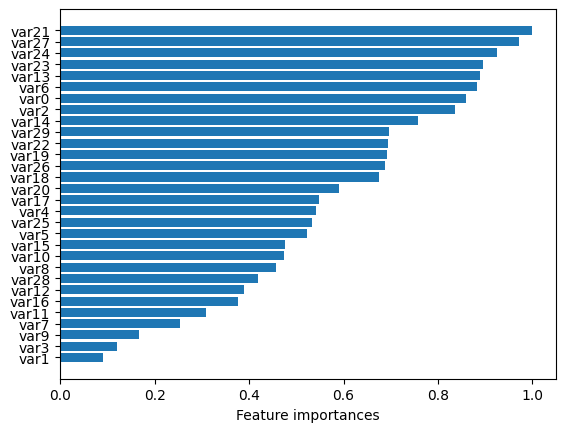

In [22]:
from matplotlib import pyplot as plt

plt.barh(global_feat_imp.index, global_feat_imp.values.flatten())
plt.xlabel("Feature importances")
plt.show();

In [23]:
y_pred_test = model.predict(X_test)


Score input data.
Apply fitted one-hot encoder.


In [24]:
df_test = local_expl.get_explanation(thresholds = [.1]*X_test.shape[1])  # make threshold more conservative (only more extreme values are considered as outliers)

Create local explanations for 16500 observations.
Using custom thresholds.


  0%|          | 0/16500 [00:00<?, ?it/s]

In [25]:
for obs, ex in enumerate(df_test.explanation.values):
    if (obs % 10) == 0:
        print(f'\nObs. {obs}:\n', ex)


Obs. 0:
 var26 (Cumul.perc.: 0.002): -8.44
var4 (Cumul.perc.: 0.021): -5.5
var29 (Cumul.perc.: 0.028): -5.66
var8 (Cumul.perc.: 0.025): -4.79
var25 (Cumul.perc.: 0.952): 5.58

Obs. 10:
 var26 (Cumul.perc.: 0.999): 10.05
var16 (Cumul.perc.: 0.966): 5.64
var5 (Cumul.perc.: 0.953): 5.65

Obs. 20:
 var12 (Cumul.perc.: 0.997): 7.92
var18 (Cumul.perc.: 0.964): 6.13

Obs. 30:
 var9 (Cumul.perc.: 0.031): -4.28
var29 (Cumul.perc.: 0.044): -4.96
var15 (Cumul.perc.: 0.97): 5.77
var22 (Cumul.perc.: 0.048): -4.37

Obs. 40:
 var29 (Cumul.perc.: 0.014): -6.62
var3 (Cumul.perc.: 0.016): -5.43

Obs. 50:
 var17 (Cumul.perc.: 0.967): 5.87
var5 (Cumul.perc.: 0.049): -4.64

Obs. 60:
 var8 (Cumul.perc.: 0.017): -5.34
var20 (Cumul.perc.: 0.035): -4.42
var16 (Cumul.perc.: 0.96): 5.45

Obs. 70:
 var25 (Cumul.perc.: 0.988): 7.5
var15 (Cumul.perc.: 0.981): 6.45

Obs. 80:
 var21 (Cumul.perc.: 0.979): 7.25
var13 (Cumul.perc.: 0.036): -5.41
var22 (Cumul.perc.: 0.959): 5.61

Obs. 90:
 var19 (Cumul.perc.: 0.01): -6.